<a href="https://colab.research.google.com/github/naenumtou/deepLearning/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/word2vec

# Import libraries
import pandas as pd
import numpy as np
import requests
import gdown
import nltk
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

# Neural networks libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional

# NLP Libraries
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Config display
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Download NLTK resource 
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Import dataset
df = pd.read_csv('BBC News Train.csv')
df = df[['Text','Category']]
df.head(10)

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
5,howard truanted to play snooker conservative...,politics
6,wales silent on grand slam talk rhys williams ...,sport
7,french honour for director parker british film...,entertainment
8,car giant hit by mercedes slump a slump in pro...,business
9,fockers fuel festive film chart comedy meet th...,entertainment


In [ ]:
# Count category
print(df.groupby(['Category']).count())

               Text
Category           
business        336
entertainment   273
politics        274
sport           346
tech            261


In [ ]:
# Change the category to number
df['Category'] = pd.Categorical(df['Category'])
df['Categories'] = df['Category'].cat.codes
df = df.drop(['Category'], axis = 1)
print(df.groupby(['Categories']).count())

            Text
Categories      
0            336
1            273
2            274
3            346
4            261


In [ ]:
# Random sample equally for each categories
df = df.groupby('Categories')['Text'].apply(lambda s: s.sample(200)).reset_index()
df = df[['Text','Categories']]
df = df.sample(frac = 1) #Random dataset
print(df.groupby(['Categories']).count())

            Text
Categories      
0            200
1            200
2            200
3            200
4            200


In [ ]:
# Download pre-trained model
binary_url = 'https://github.com/BrownDSI/word2vec-slim/releases/' + \
             'download/v0.1/GoogleNews-vectors-negative300-slim.bin.gz'
r = requests.get(binary_url)
open('google-word2vec-slim.bin.gz', 'wb').write(r.content);

In [ ]:
# Load model contrained abot 300k of vocabs
model = KeyedVectors.load_word2vec_format('google-word2vec-slim.bin.gz', binary = True)

In [ ]:
# Features extraction
V = list(model.vocab.keys())
stop = 80000 #Define how many vocabs used
W = None

for v, i in zip(V, range(len(V))):
  if i % 5000 == 0:
    print(f'word processing... {i}')
  if i == stop:
    break  
  w = model[v]
  if W is None:
    W = w.copy()
  else:
    W = np.vstack((W, w))

V = V[:stop] #Cutting vocabs list with defined value

print(len(V))
print(W.shape)

word processing... 0
word processing... 5000
word processing... 10000
word processing... 15000
word processing... 20000
word processing... 25000
word processing... 30000
word processing... 35000
word processing... 40000
word processing... 45000
word processing... 50000
word processing... 55000
word processing... 60000
word processing... 65000
word processing... 70000
word processing... 75000
word processing... 80000
80000
(80000, 300)


In [ ]:
# Set up the stop words (need to download nltk.corpus)
stop_words = set(stopwords.words('english'))

# Function word tokenize and return as index
def xidx(x):
  x_idx = []
  heading = word_tokenize(x)
  # Remove all syntax (need to download nltk.punkt)
  w = [word.lower() for word in heading if word.isalnum()]
  # Remove stopping words
  w = [word for word in w if not word in stop_words]
  for h in heading:
    if h in V:
      x_idx.append(V.index(h))
  return np.array(x_idx)

In [ ]:
# Data length adjustment for neural network
Xtrain_idx = []
max_len = 0

for x, i in zip(df['Text'], range(len(df['Text']))):
  if i % 100 == 0:
    print(f'heading process... {i}')
  Xtrain_idx.append(xidx(x))
  if len(Xtrain_idx[-1]) > max_len:
    max_len = len(Xtrain_idx[-1])
  
print(max_len)

heading process... 0
heading process... 100
heading process... 200
heading process... 300
heading process... 400
heading process... 500
heading process... 600
heading process... 700
heading process... 800
heading process... 900
2884


In [ ]:
# Zero padding for vocab list
V = [''] + V
print(len(V))

# Zero padding with randow for word vector
W = np.vstack((np.random.rand(*W[0].shape), W))
print(W.shape)

80002
(80002, 300)


In [ ]:
# Zero padding for training data
for i, x in zip(range(len(Xtrain_idx)), Xtrain_idx):
  if i % 100 == 0:
    print(f'padding process... {i}')
  if len(x) < max_len:
    Xtrain_idx[i] = np.hstack((x, np.zeros(max_len - len(x))))

# Convert to numpy array for neural network
Xtrain_idx = np.array(Xtrain_idx)

padding process... 0
padding process... 100
padding process... 200
padding process... 300
padding process... 400
padding process... 500
padding process... 600
padding process... 700
padding process... 800
padding process... 900


In [ ]:
# Design the Long Short Term Memory (LSTM) Neural Networks
model = Sequential()

# Layer 1: Embedding layer
model.add(Embedding(W.shape[0], W.shape[1], name = 'embed_layer'))

# Layer 2: LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Dropout(0.2))

# Layer 3: LSTM layer
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))

# Layer 4: Dense layer (Hidden layer)
model.add(Dense(24, activation = 'relu'))
model.add(Dropout(0.1))

# Layer 5: Output layer
model.add(Dense(5, activation = 'softmax')) #Five categories (0-4) answer for news

# Defining the optimizer
optz = tf.keras.optimizers.Adam(lr = 0.001)

# Complie the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optz, metrics = ['accuracy'])

# Model overview
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed_layer (Embedding)      (None, None, 300)         24000600  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 128)         186880    
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                1560      
_________________________________________________________________
dropout_20 (Dropout)         (None, 24)               

In [ ]:
# Weight adjustment for embedding layer
model.get_layer('embed_layer').set_weights([W])
model.get_layer('embed_layer').trainable = True

In [ ]:
# Fitting LSTM Model
logs = model.fit(Xtrain_idx, np.array(df['Categories']), epochs = 30,  batch_size = 64, validation_split = 0.2)

Epoch 1/30
13/13 [==============================] - 13s 964ms/step - loss: 1.6292 - accuracy: 0.1863 - val_loss: 1.5980 - val_accuracy: 0.2300
Epoch 2/30
13/13 [==============================] - 11s 870ms/step - loss: 1.5900 - accuracy: 0.2237 - val_loss: 1.5630 - val_accuracy: 0.2950
Epoch 3/30
13/13 [==============================] - 11s 872ms/step - loss: 1.4661 - accuracy: 0.3650 - val_loss: 1.5021 - val_accuracy: 0.3000
Epoch 4/30
13/13 [==============================] - 11s 867ms/step - loss: 1.1945 - accuracy: 0.4500 - val_loss: 1.1220 - val_accuracy: 0.4900
Epoch 5/30
13/13 [==============================] - 11s 880ms/step - loss: 1.0060 - accuracy: 0.5350 - val_loss: 1.0296 - val_accuracy: 0.5650
Epoch 6/30
13/13 [==============================] - 11s 879ms/step - loss: 0.8052 - accuracy: 0.6812 - val_loss: 0.9026 - val_accuracy: 0.6800
Epoch 7/30
13/13 [==============================] - 11s 874ms/step - loss: 0.6631 - accuracy: 0.7312 - val_loss: 0.8621 - val_accuracy: 0.6850

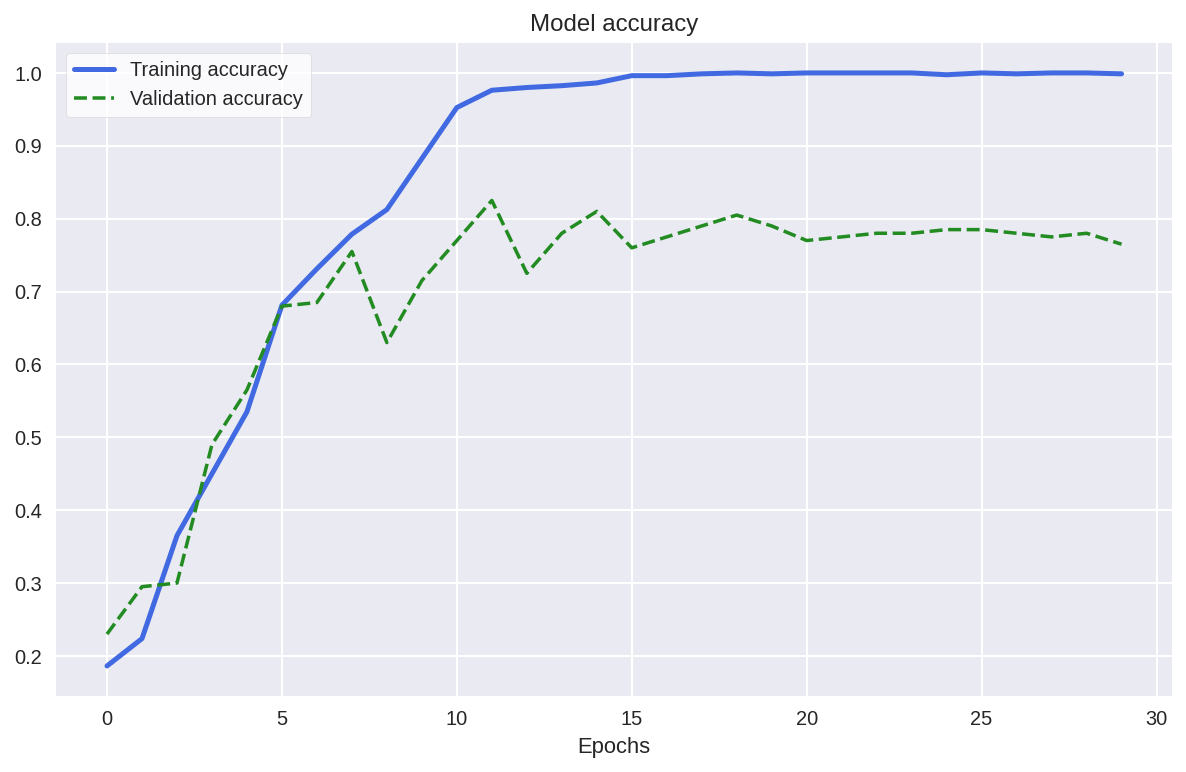

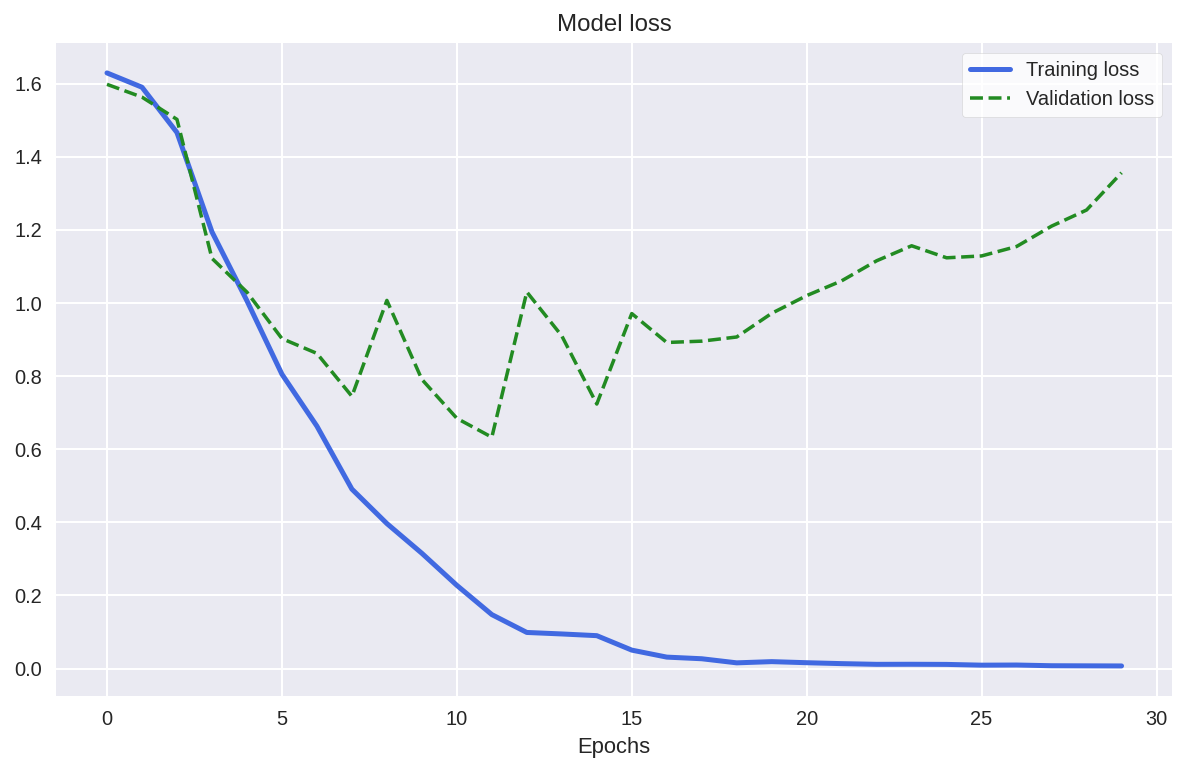

In [ ]:
# Plot loss function
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Model accuracy')
  plt.xlabel('Epochs')
  plt.plot(logs.history['accuracy'], c = 'royalblue', linewidth = 2.5, label = 'Training accuracy')
  plt.plot(logs.history['val_accuracy'], c = 'forestgreen', linestyle = '--', label = 'Validation accuracy')
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()

plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Model loss')
  plt.xlabel('Epochs')
  plt.plot(logs.history['loss'], c = 'royalblue', linewidth = 2.5, label = 'Training loss')
  plt.plot(logs.history['val_loss'], c = 'forestgreen', linestyle = '--', label = 'Validation loss')
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()

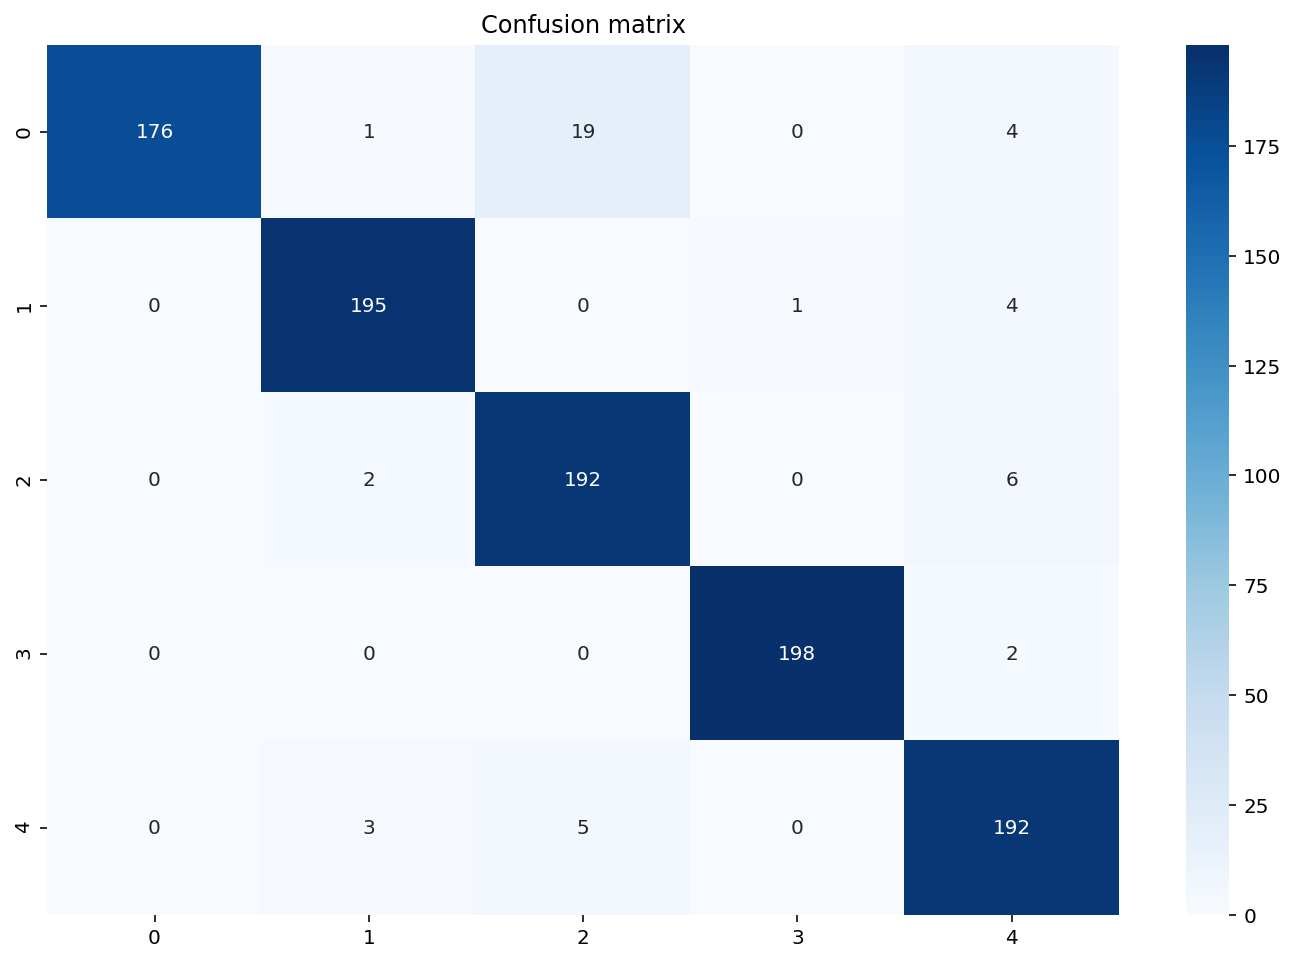

In [ ]:
# Prediction and performance
pred = model.predict(Xtrain_idx).argmax(axis = 1)
cf_matrix = confusion_matrix(np.array(df['Categories']), pred)

# Plot confusion matrix
plt.figure(figsize = (12, 8))
plt.title('Confusion matrix')
sns.heatmap(cf_matrix, annot = True, fmt = '.0f', cmap = plt.cm.Blues)
plt.show()

In [ ]:
# Save model
model.save('newsclassification.model')